<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Pulse Schedules

The `pulse` module allows quantum experiments to be described at the level of pulses. For IBMQ devices these are microwave pulses applied to our superconducting qubits. 

The pulse `Schedule`, `Instruction`, `Command` and `Channel` are the main objects of the pulse module. 



All instances of these objects are **immutable**, which results in:
- An API that is easier to reason about
- Objects that may be reused many times as components of parent objects without the problem of underlying children object's guarantees changing

In [1]:
%matplotlib inline

In [63]:
import numpy as np
from qiskit.pulse.channels import (DriveChannel, MeasureChannel, ControlChannel, 
                                   AcquireChannel, MemorySlot, SnapshotChannel)
from qiskit.pulse.commands import (SamplePulse, FrameChange, PersistentValue,
                                   Acquire, Snapshot)
from qiskit.pulse import pulse_lib, Schedule

# Channels

`Channel`s correspond to physical channels on the backend. `Channel`s are combined with `Command`s to form an `Instruction`.

As all channels correspond to physical channels on a device, they have an `index` which specifies their corresponding device channel and a `buffer`, which is the buffering delay in units `dt/dtm` that must be added between commands on the same channel when `appending`.

The fundamental channel types are: 
- `DriveChannel`: Qubit drive channel. The index channel corresponds to the system qubit index.
- `MeasureChannel`: Qubit stimulus channel. The channel index corresponds to the system qubit index.
- `ControlChannel`: Arbitrary control channel with action specified by Hamiltonian provided by device. The function of this channel must be extracted from the system Hamiltonian.
- `AcquireChannel`: Qubit acquisition channel. The channel index corresponds to the system qubit index.
- `MemorySlot`: Channel for storage of qubit results for measurement levels 0,1 and 2. The output of an `Acquire` of any qubit may be stored in any `MemorySlot`.
- `RegisterSlot`: Channel for storage of qubit results for use with conditional commands. The output of an `Acquire` may be mapped to corresponding `RegisterSlot` with indexes specified by the `backend` configurations `register_map`.
- `Snapshot`: Channel for snapshots (for use with simulators only).

Channels may be declared using the following:

In [3]:
drive_ch0 = DriveChannel(0, buffer=2)
meas_ch0 = MeasureChannel(0, buffer=2)
control_ch0 = ControlChannel(0, buffer=2)
acquire_ch0 = AcquireChannel(0, buffer=0)
memory_slot0 = MemorySlot(0)

drive_ch1 = DriveChannel(1, buffer=2)
meas_ch1 = MeasureChannel(1, buffer=2)
control_ch1 = ControlChannel(1, buffer=2)
acquire_ch1 = AcquireChannel(1, buffer=0)
memory_slot1 = MemorySlot(1)

The buffer parameter is optional and both index and buffer may be accessed.

In [4]:
print(drive_ch0.index)
print(drive_ch0.buffer)

0
2


Channels can be checked for equivalency. This check is based on the channel index as every channel corresponds to a unique device channel.

In [5]:
drive_ch0 == drive_ch0

True

In [6]:
drive_ch0 == DriveChannel(0)

True

In [7]:
drive_ch0 == drive_ch1

False

## Commands
Pulse `Command`s specify commands to be completed on a device `Channel`. Once defined a `Command` is *immutable* and may be used many times on many different channels. Some `Command`s may only be applied to specific `Channel` types.

The fundamental commands for the `PulseChannel` are:
- `SamplePulse`: A pulse specified as a complex array of samples to be output out on the corresponding channel. Each pulse sample corresponds to a timestep of unit `dt` on the backend.
- `FrameChange`: A persistent framechange of the phase of all future pulses on the corresponding channel. `Framechange`s have zero duration on the backend.
- `PersistentValue`: A pulse that will holds its value until the next pulse on the corresponding channel. `PersistentValue` pulses will have variable duration on the backend as they depend on subsequent commands.

In [31]:
sine_pulse = SamplePulse(np.sin(np.linspace(0,4*np.pi, 20)), name='random_pulse')
pi_fc = FrameChange(np.pi)
one_pv = PersistentValue(1.0)

The `name` for commands is optional if it is not supplied it will be automatically assigned.

`SamplePulse`s may be easily visualized

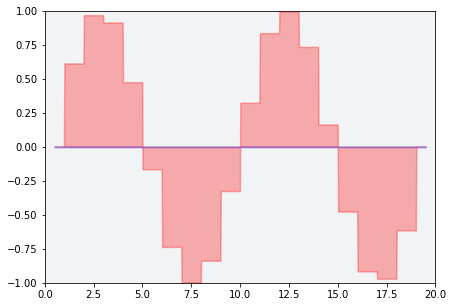

In [32]:
sine_pulse.draw()

The fundamental command for the `AcquireChannel` is:
- `Acquire`: Specify the acquisition, kerneling and discrimination of measurement data on a set of acquisition channels

In [33]:
acquire = Acquire(100)

The fundamental command for the `SnapshotChannel` is:
- `Snapshot`: A snapshot of the simulated system.

In [11]:
snapshot = Snapshot('test_snapshot', 'state')

All `Command`s have a `duration` attribute. This may be fixed as for the case of the `FrameChange` having zero duration, or dependent on the command as is the case for the `SamplePulse` who's duration is defined by the number of samples in the pulse.

In [12]:
sine_pulse.duration

20

In [13]:
pi_fc.duration

0

## Instructions

An `Instruction` may be created by applying a `Command` to a set of `Channel`s. Each `Command` type has a corresponding `Instruction` type. An `Instruction` is obtained from a `Command` by calling `to_instruction` or directly calling the `Command`. The `Channel`s to apply the command to are supplied as arguments to the above call.

In [48]:
sine_instr = sine_pulse.to_instruction(drive_ch0)
sine_instr_equivalent = sine_pulse(drive_ch0)

Certain instructions such as the `AcquireInstruction` accept multiple channels. In this case `AcquireInstruction` accepts up to three lists of the same size. These are lists of `AcquireChannel`s, `MemorySlot`s and `RegisterSlot`s. This allows the acquisition, kerneling and discrimination of multiple qubit to be combined and the output of a given channel to directed to the desired storage location.

In [34]:
acquire_instr = acquire([acquire_ch0, acquire_ch1], [memory_slot0, memory_slot1])

`Instructions` can also be plotted

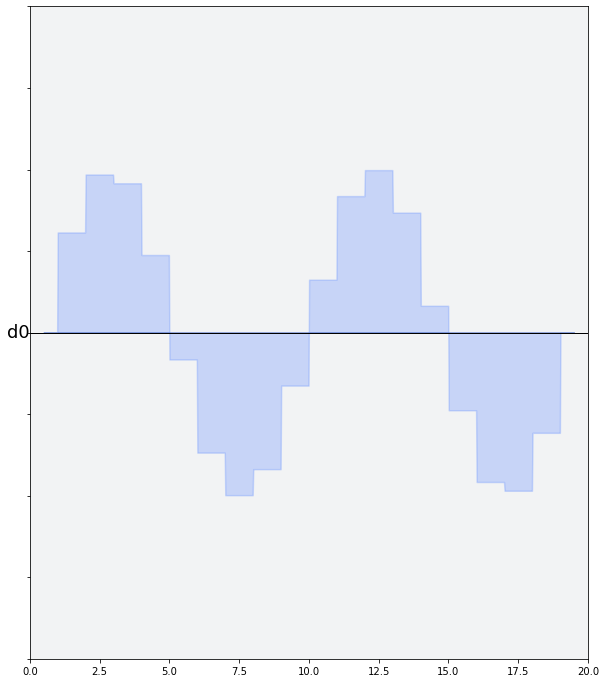

In [38]:
sine_instr.draw()

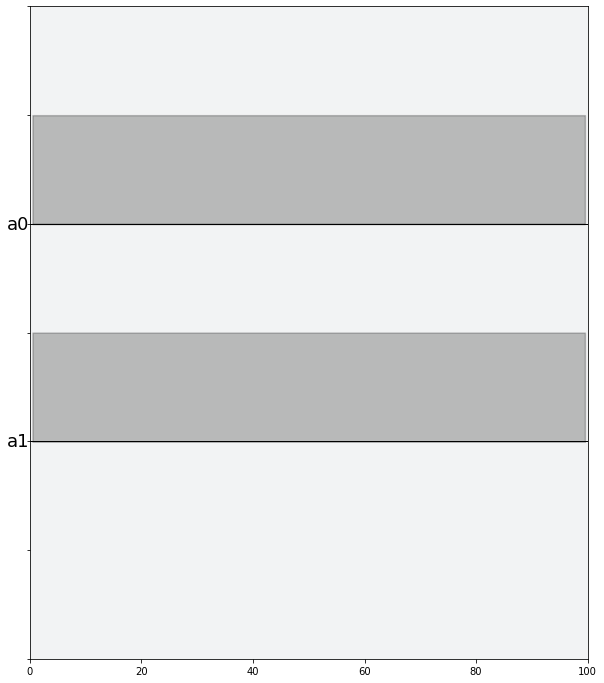

In [39]:
acquire_instr.draw()

`Instruction`s have a notion of time. Each instruction has a `start_time` and a set of `Timeslot`s that the instruction occupies. 

In [40]:
sine_instr.start_time

0

In [41]:
sine_instr.duration

20

`Timeslot`s are occupied on a channel-by-channel basis and may not overlap on a given channel. They are used to enforce time ordering within a pulse schedule.

In [42]:
sine_instr.timeslots.is_mergeable_with(sine_instr.timeslots)

False

In [43]:
sine_instr.timeslots.is_mergeable_with(acquire_instr.timeslots)

True

## Schedules
Pulse schedules are made by scheduling `Instruction`s. The `Schedule` may be viewed as a container for `Instruction`s and `Schedule`s shifted in time. In this way a simple `Schedule`s may be treated as a building blocks for more complicated `Schedule`s. 

In [44]:
sched = Schedule(name='test_schedule')

In [52]:
pulse_sched = Schedule(sine_instr, name='sine_schedule')
acquire_sched = Schedule((10, acquire_instr), name='acquire_schedule')

There are three basic methods for manipulating `Schedule`s. These methods all return a new `Schedule` which modifies the attributes of the underlying children `Schedule`s or `Instruction`s.

1. `union`: Joins the supplied schedules and instructions, merging their timeslots together. If timeslots overlap an error will be raised.
2. `shift`: Shifts the initial time of the `Schedule` or `Instruction` by an amount.
3. `append`: Append the supplied schedule or instruction at the last time of the parent schedule plus the maximum buffer over the set of all channels shared by the parent and child schedules.

Note that there is no requirement that a parent `Schedule` must contain all of the `Channel`s of a child `Schedule` or `Instruction` to which it is being joined with. The set of `Channel`s present in the `Schedule` will automatically be extended.

In [53]:
union_sched = pulse_sched.union(acquire_sched)

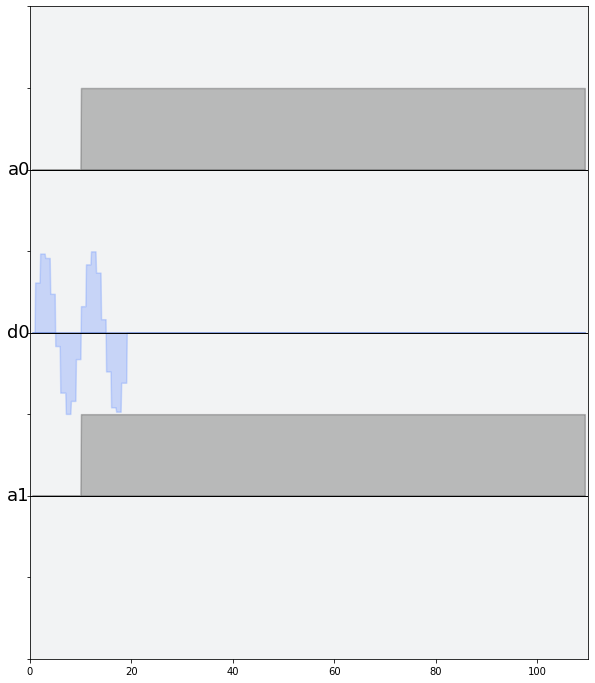

In [54]:
union_sched.draw()

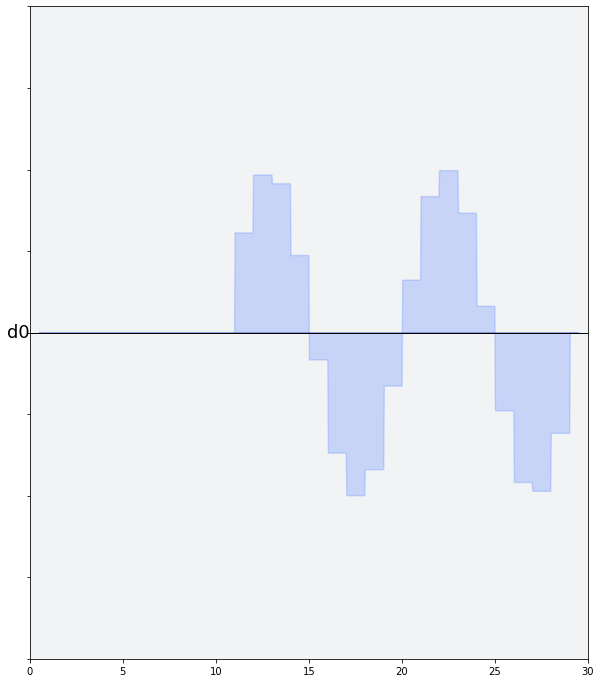

In [55]:
shifted_pulse_sched = pulse_sched.shift(10)
shifted_pulse_sched.draw()

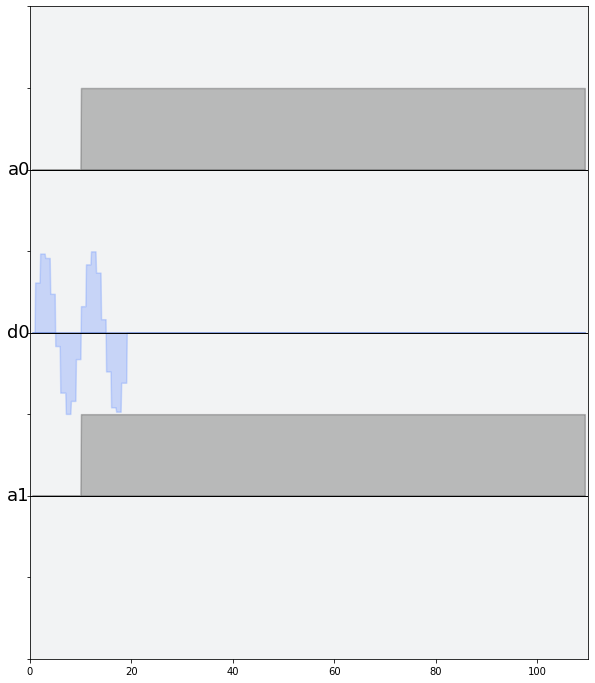

In [56]:
pulse_sched.append(acquire_sched).draw()

For ease of use it is also possible to build schedules directly from `Instruction`s. Note that a `Schedule` will still be returned.

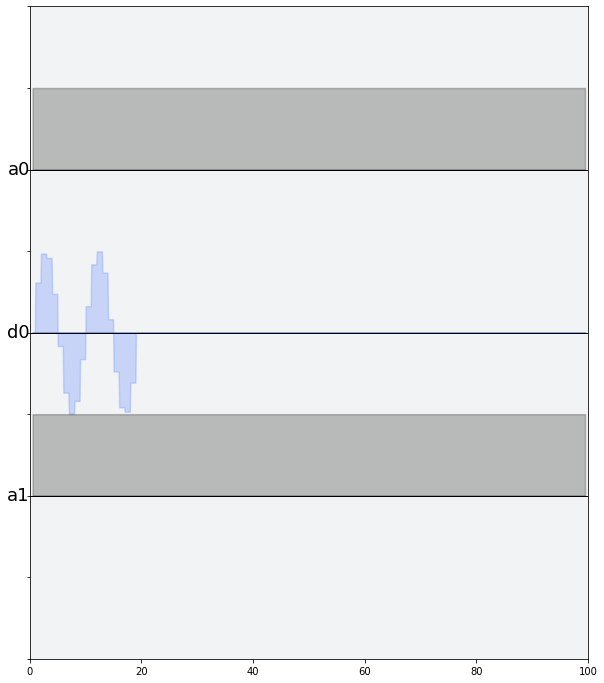

In [57]:
combined_schedule = sine_instr.append(acquire_instr)
combined_schedule.draw()

### Syntactic Sugar

To make it easier to build pulse schedules there exists a **syntactic sugar** for operating on schedules

1. `a.union(b)` $\equiv$ `a | b`
2. `a.append(b)` $\equiv$ `a + b`
3. `a.shift(time)` $\equiv$ `a << time`

As the `Schedule` for the above methods emulate numeric types this enables a simple way of construction composite pulse schedules.

Below we construct two equivalent schedules one with the syntactic sugar and one without

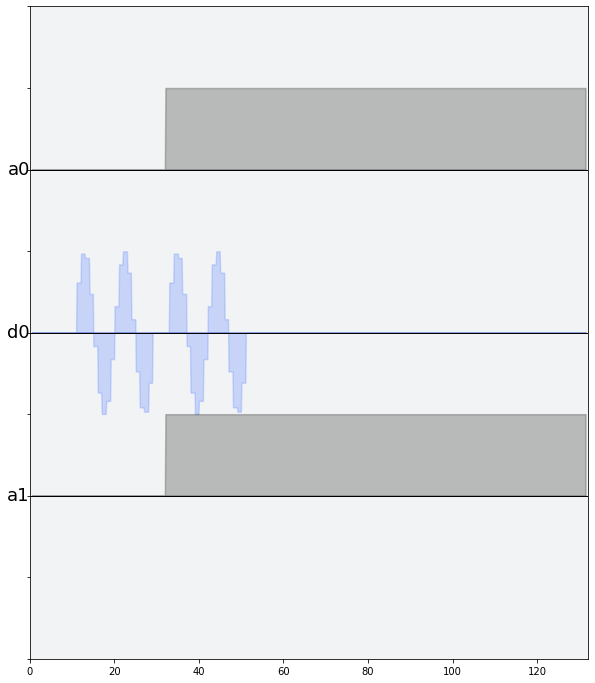

In [58]:
sched = Schedule(name='verbose')
sched = sched.union(sine_instr.shift(10))
sched = sched.append(acquire_instr.append(sine_instr))
sched.draw()

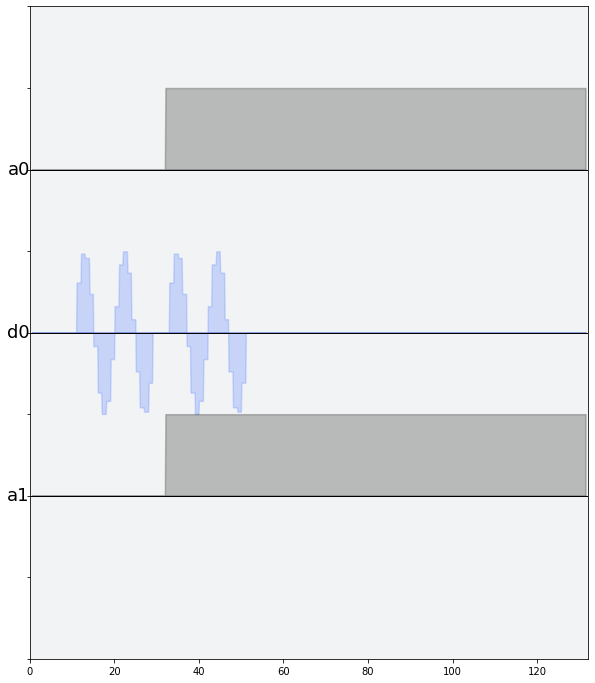

In [59]:
sched = Schedule(name='syntactic_sugar')
sched |= sine_instr << 10
sched += acquire_instr + sine_instr
sched.draw()

## Outcomes of Pulse Schedules

There are three (integer) measurement pulse levels (`meas_levels`) for pulse outputs which are triggered by `Acquire` commands and stored into the desired `MemorySlots`:
- Measurement level 0: Return the sampled measurement output from the `AcquireChannel` after mixing down with the measurement stimulus LO. There will be a large amount of data associated with measurement level.
- Measurement level 1: Return the data after the application of a user specified (or default if not specified) kernel.
- Measurement level 2: Return the discriminated counts after the application of a measurement kernel and discriminator. This corresponds to the measurement output of a quantum circuit. See the [circuits notebook](quantum_circuits.ipynb) for more information.

For measurement level 0 and 1 there is another supported measurement result post-processing modifier, `meas_return`:
- `single`: Return the results for each individual shot.
- `avg`: Average the results over all shots.

<div class="alert alert-block alert-info">
<b>Note:</b> All modes may not be supported on all backends due to different system constraints.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Methods below are not executed as the pulse simulator has not yet been released for Qiskit.
</div>

Schedules may be executed in a similar manner to schedules 

```python
job = execute(sched, meas_level=1, meas_return='avg')
result = job.result()
```

For measurement levels 0 and 1 results may be extracted from the result object with

```python 
result.get_memory(schedule)
```

For measurement levels 2, results are extracted in the same way as for circuit results. To get individual shot counts,

```python
result.get_memory(schedule)
```

and for binned counts

```python
job = execute(sched, meas_level=2)
result = job.result()
result.get_counts(schedule)
```